In [11]:
data_path = "/scratch/cl6707/Shared_Datasets/NSD_MindEye"
nsd_root = "/scratch/cl6707/Projects/neuro_interp/data/NSD/"
stim_root = nsd_root + "nsddata_stimuli/stimuli/nsd/"
beta_root = nsd_root + "nsddata_betas/ppdata/"
mask_root = nsd_root + "nsddata/ppdata/"
nsd_mindroot = '/scratch/cl6707/Shared_Datasets/NSD_MindEye'

subj = 1
import os
os.environ["PROTOCOL_BUFFERS_PYTHON_IMPLEMENTATION"] = "python"
import sys
sys.path.append('/scratch/cl6707/Projects/neuro_interp/data/NSD/nsd')
import json
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torchvision import transforms
from tqdm.notebook import tqdm
from datetime import datetime
import webdataset as wds
import PIL
import argparse

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
local_rank = 0
print("device:",device)

import utils
from models import Clipper, OpenClipper, BrainNetwork, BrainDiffusionPrior, BrainDiffusionPriorOld, Voxel2StableDiffusionModel, VersatileDiffusionPriorNetwork

if utils.is_interactive():
    %load_ext autoreload
    %autoreload 2

seed=42
utils.seed_everything(seed=seed)

from torch.utils.data import Dataset
from src.file_utility import load_mask_from_nii, view_data
from src.file_utility import save_stuff, flatten_dict, embed_dict
%matplotlib inline
fpX = np.float32
import src.numpy_utility as pnu
from src.file_utility import save_stuff, flatten_dict, embed_dict
from src.file_utility import load_mask_from_nii, view_data
from src.roi import roi_map, iterate_roi
from src.load_nsd import  image_feature_fn, data_split
import h5py
import glob
import torchvision.models as models
from sklearn.decomposition import PCA
from PIL import Image
from src.numpy_utility import mosaic_vis, iterate_minibatches
from nilearn.decoding import SpaceNetRegressor
import nibabel as nib

import tensorflow as tf
import tensorflow_hub as hub
guse = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

device: cuda
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
subj =1
voxel_roi_full  = load_mask_from_nii(mask_root + "subj%02d/func1pt8mm/roi/prf-visualrois.nii.gz"%subj)

if subj == 1:
    num_voxels = 15724
elif subj == 2:
    num_voxels = 14278
elif subj == 3:
    num_voxels = 15226
elif subj == 4:
    num_voxels = 13153
elif subj == 5:
    num_voxels = 13039
elif subj == 6:
    num_voxels = 17907
elif subj == 7:
    num_voxels = 12682
elif subj == 8:
    num_voxels = 14386

In [13]:
print('Pulling NSD webdataset data...')
# Multi-GPU config #
from accelerate import Accelerator
accelerator = Accelerator(split_batches=False,mixed_precision='fp16')  
print("PID of this process =",os.getpid())
print = accelerator.print # only print if local_rank=0
device = accelerator.device
print("device:",device)
num_devices = torch.cuda.device_count()
if num_devices==0: num_devices = 1
num_workers = num_devices
print(accelerator.state)
local_rank = accelerator.state.local_process_index
world_size = accelerator.state.num_processes
distributed = not accelerator.state.distributed_type == 'NO'
print("distributed =",distributed, "num_devices =", num_devices, "local rank =", local_rank, "world size =", world_size)



train_url = "{" + f"{data_path}/webdataset_avg_split/train/train_subj0{subj}_" + "{0..17}.tar," + f"{data_path}/webdataset_avg_split/val/val_subj0{subj}_0.tar" + "}"
val_url = f"{data_path}/webdataset_avg_split/test/test_subj0{subj}_" + "{0..1}.tar"
print(train_url,"\n",val_url)
meta_url = f"{data_path}/webdataset_avg_split/metadata_subj0{subj}.json"
num_train = 8559 + 300
num_val = 982
batch_size = 512
print('Prepping train and validation dataloaders...')
train_dl, val_dl, num_train, num_val = utils.get_dataloaders(
    batch_size,'images',
    num_devices=num_devices,
    num_workers=num_workers,
    train_url=train_url,
    val_url=val_url,
    meta_url=meta_url,
    num_train=num_train,
    num_val=num_val,
    val_batch_size=300,
    cache_dir=data_path, #"/tmp/wds-cache",
    seed=seed,
    voxels_key='nsdgeneral.npy', # 'nsdgeneral.npy' (1d), 'wholebrain_3d.npy'(3d)
    to_tuple=["voxels", "images", "coco","trial"],
    local_rank=local_rank,
    world_size=world_size,
)

Pulling NSD webdataset data...
PID of this process = 2997048
device: cuda
Distributed environment: NO
Num processes: 1
Process index: 0
Local process index: 0
Device: cuda

Mixed precision type: fp16

distributed = False num_devices = 1 local rank = 0 world size = 1
{/scratch/cl6707/Shared_Datasets/NSD_MindEye/webdataset_avg_split/train/train_subj01_{0..17}.tar,/scratch/cl6707/Shared_Datasets/NSD_MindEye/webdataset_avg_split/val/val_subj01_0.tar} 
 /scratch/cl6707/Shared_Datasets/NSD_MindEye/webdataset_avg_split/test/test_subj01_{0..1}.tar
Prepping train and validation dataloaders...
Getting dataloaders...

num_train 8859
global_batch_size 512
batch_size 512
num_workers 1
num_batches 17
num_worker_batches 17

num_val 982
val_num_batches 1
val_batch_size 300


In [17]:
annotation_all = np.load(nsd_mindroot + '/subj%02d_annot.npy'%subj,allow_pickle=True)
nsdgeneral_affine = nib.load('/scratch/cl6707/Projects/neuro_interp/data/NSD/nsddata/ppdata/subj01/func1pt8mm/roi/nsdgeneral.nii.gz').affine
nsdgeneral_roi_mask = nib.load('/scratch/cl6707/Projects/neuro_interp/data/NSD/nsddata/ppdata/subj01/func1pt8mm/roi/nsdgeneral.nii.gz').get_fdata()==1
anat_img = '/scratch/cl6707/Projects/neuro_interp/data/NSD/nsddata/ppdata/subj01/func1pt8mm/T1_to_func1pt8mm.nii.gz'
from transformers import GPT2Tokenizer, GPT2Model
tokenizer_gpt = GPT2Tokenizer.from_pretrained('gpt2')
tokenizer_gpt.pad_token = tokenizer_gpt.eos_token
gpt = GPT2Model.from_pretrained('gpt2').to(device)
gpt = gpt.eval()


def reconstruct_volume_corrected(vol_shape, binary_mask, data_vol, order='C'):
    
    view_vol = np.ones(np.prod(vol_shape), dtype=np.float32) * np.nan
    
    idx_mask = np.where(binary_mask)[0]
    
    view_vol[idx_mask] = data_vol
    return view_vol.reshape(vol_shape, order=order)

@torch.no_grad()
def get_guse(annotation):
    B = annotation.shape[0]
    annot_embed_all = np.zeros((B,512))
    for b in range(B):
        annot_embed = guse(annotation[b][0]).cpu().numpy()
        corr_mat = np.corrcoef(annot_embed)
        max_index = np.argmax(corr_mat.mean(axis=0),axis=0)
        annot_embed_all[b] = annot_embed[max_index]
    
    return torch.tensor(annot_embed_all).to(device).float()

@torch.no_grad()
def get_gpt(annotation):
    B = annotation.shape[0]
    annot_embed_all = np.zeros((B,768))
    for b in range(B):
        encoded_input = tokenizer_gpt(annotation[b][0], padding=True, truncation=True,return_tensors='pt').to(device)
        output = gpt(**encoded_input)
        annot_embed = output.last_hidden_state.mean(dim=1).cpu().numpy()
        corr_mat = np.corrcoef(annot_embed)
        max_index = np.argmax(corr_mat.mean(axis=0),axis=0)
        annot_embed_all[b] = annot_embed[max_index]
    
    return torch.tensor(annot_embed_all).to(device).float()



# Models

## Linear Mapping Model

In [6]:
import torch
import torch.nn as nn

class LinearModel(nn.Module):
    def __init__(self, input_size, output_size, alpha, l1_ratio, graph_structure):
        super(LinearModel, self).__init__()
        self.linear = nn.Linear(input_size, output_size)
        self.alpha = alpha
        self.l1_ratio = l1_ratio
        self.graph_structure = graph_structure

    def forward(self, x):
        return self.linear(x)

    def tv_l1_regularization(self):
        weights = self.linear.weight
        grad_x = torch.abs(weights[:, 1:] - weights[:, :-1])
        grad_y = torch.abs(weights[1:, :] - weights[:-1, :])
        tv_norm = torch.sum(grad_x) + torch.sum(grad_y)
        l1_norm = torch.sum(torch.abs(weights))
        return self.l1_ratio * tv_norm + (1 - self.l1_ratio) * l1_norm

In [11]:
model = LinearModel(num_voxels, 512,1,0.5, None)
model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

from scipy.stats import pearsonr
loss_dict_train = {'tv_l1':[],
                'mse':[]
                }
tv_weight = 1e-3
pcc_list_train = []

epoch_num = 10
for epoch in tqdm(range(epoch_num)):
    for voxels, images, coco, trial in train_dl:
        pcc_all = []
        voxels = voxels.float().to(device)
        voxels = voxels.mean(axis=1)
        guse_embed = get_guse(annotation_all[trial])
        optimizer.zero_grad()
        outputs = model(voxels)
        tv_l1 = model.tv_l1_regularization()
        mse = criterion(outputs, guse_embed)
        loss_dict_train['tv_l1'].append(tv_l1.item()*tv_weight)
        loss_dict_train['mse'].append(mse.item())
        loss = mse + tv_weight*tv_l1
        loss.backward() 
        optimizer.step()
        # calculte PCC between outputs and guse_embed
        pcc = [pearsonr(outputs[i].detach().cpu().numpy(), guse_embed[i].detach().cpu().numpy(),)[0] for i in range(len(outputs))]
        pcc_all += pcc
    pcc_list_train.append(np.mean(pcc_all))

100%|██████████| 10/10 [16:33<00:00, 99.34s/it]


In [12]:
loss_dict_val = {'tv_l1':[],
                'mse':[]
                }
pcc_list_val = []

model.eval()
for voxels, images, coco, trial in val_dl:
    voxels = voxels.float().to(device)
    voxels = voxels.mean(axis=1)
    guse_embed = get_guse(annotation_all[trial])
    outputs = model(voxels)
    tv_l1 = model.tv_l1_regularization()
    mse = criterion(outputs, guse_embed)
    loss_dict_val['tv_l1'].append(tv_l1.item())
    loss_dict_val['mse'].append(mse.item())
    loss = mse + tv_weight*tv_l1
    # calculte PCC between outputs and guse_embed
    pcc = [pearsonr(outputs[i].detach().cpu().numpy(), guse_embed[i].detach().cpu().numpy(),)[0] for i in range(len(outputs))]
    pcc_list_val += pcc

print('Val PCC:',np.mean(pcc_list_val))
# save model
torch.save(model.state_dict(), './output/subj%02d_linear_model.pt'%subj)

Val PCC: 0.45475639118905836


### Visualize weight

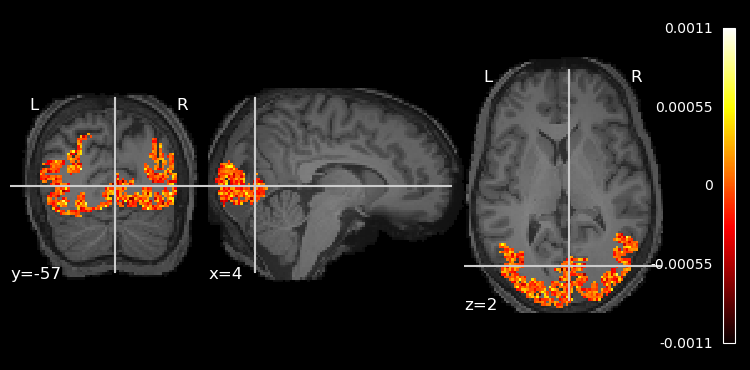

In [9]:
weights = model.linear.weight.detach().cpu().numpy()
weights = weights.mean(axis=0)
voxel_weight = weights
reconstructed_weight = reconstruct_volume_corrected(nsdgeneral_roi_mask.shape, nsdgeneral_roi_mask.flatten(), voxel_weight)
reconstructed_weight = np.nan_to_num(reconstructed_weight)
ni_img = nib.Nifti1Image(reconstructed_weight,affine=nsdgeneral_affine)
from nilearn.plotting import plot_stat_map
plot_stat_map(ni_img,
                bg_img=anat_img,
                    cmap='hot')

### oclussion on voxel

In [ ]:
# weights for each voxel
weights = model.linear.weight.detach().cpu().numpy()
weights = weights.mean(axis=0)
voxel_weight = weights
# get top 10 voxels by absolute value
top_n = 10
top_voxel = np.argsort(np.abs(voxel_weight))[::-1][:top_n]
model_voxels = {voxel_pos:LinearModel(num_voxels, 512,1,0.5, None) for voxel_pos in top_voxel}
optimizer_voxels = {voxel_pos:torch.optim.Adam(model_voxels[voxel_pos].parameters(), lr=1e-3) for voxel_pos in top_voxel}
# for each voxel in the top10, mask out it and train the model again, see if the performance drops
pcc_voxel_dict = {}

for voxel_pos in tqdm(top_voxel):
    model_voxels[voxel_pos].to(device)
    for epoch in tqdm(range(epoch_num)):
        for voxels, images, coco, trial in train_dl:
            pcc_all = []
            voxels = voxels.float().to(device)
            voxels = voxels.mean(axis=1)
            guse_embed = get_guse(annotation_all[trial])
            optimizer_voxels[voxel_pos].zero_grad()
            outputs = model_voxels[voxel_pos](voxels)
            tv_l1 = model_voxels[voxel_pos].tv_l1_regularization()
            mse = criterion(outputs, guse_embed)
            loss_dict_train['tv_l1'].append(tv_l1.item()*tv_weight)
            loss_dict_train['mse'].append(mse.item())
            loss = mse + tv_weight*tv_l1
            loss.backward() 
            optimizer_voxels[voxel_pos].step()
            # calculte PCC between outputs and guse_embed
            pcc = [pearsonr(outputs[i].detach().cpu().numpy(), guse_embed[i].detach().cpu().numpy(),)[0] for i in range(len(outputs))]
            pcc_all += pcc
        pcc_list_train.append(np.mean(pcc_all))
    
    loss_dict_val = {'tv_l1':[],
                    'mse':[]
                    }
    pcc_list_val = []

    model_voxels[voxel_pos].eval()
    for voxels, images, coco, trial in val_dl:
        voxels = voxels.float().to(device)
        voxels = voxels.mean(axis=1)
        guse_embed = get_guse(annotation_all[trial])
        outputs = model_voxels[voxel_pos](voxels)
        tv_l1 = model_voxels[voxel_pos].tv_l1_regularization()
        mse = criterion(outputs, guse_embed)
        loss_dict_val['tv_l1'].append(tv_l1.item())
        loss_dict_val['mse'].append(mse.item())
        loss = mse + tv_weight*tv_l1
        # calculte PCC between outputs and guse_embed
        pcc = [pearsonr(outputs[i].detach().cpu().numpy(), guse_embed[i].detach().cpu().numpy(),)[0] for i in range(len(outputs))]
        pcc_list_val += pcc

    print('Val PCC:',np.mean(pcc_list_val))
    pcc_voxel_dict[voxel_pos] = np.mean(pcc_list_val)
    # save model
    torch.save(model_voxels[voxel_pos].state_dict(), './output/voxel_occlusion/subj%02d_linear_model_voxel%02d.pt'%(subj,voxel_pos))xw

## MLP Model for regression

In [15]:
from functools import partial
class BrainNetwork_MLP(nn.Module):
    def __init__(self, out_dim=512, in_dim=15724, h=4096, n_blocks=4, norm_type='ln', act_first=False):
        super().__init__()
        norm_func = partial(nn.BatchNorm1d, num_features=h) if norm_type == 'bn' else partial(nn.LayerNorm, normalized_shape=h)
        act_fn = partial(nn.ReLU, inplace=True) if norm_type == 'bn' else nn.GELU
        act_and_norm = (act_fn, norm_func) if act_first else (norm_func, act_fn)
        self.lin0 = nn.Sequential(
            nn.Linear(in_dim, h),
            *[item() for item in act_and_norm],
            nn.Dropout(0.5),
        )
        self.mlp = nn.ModuleList([
            nn.Sequential(
                nn.Linear(h, h),
                *[item() for item in act_and_norm],
                nn.Dropout(0.15)
            ) for _ in range(n_blocks)
        ])
        self.lin1 = nn.Linear(h, out_dim, bias=True)
        self.n_blocks = n_blocks

        
    def forward(self, x):
        '''
            bs, 1, 15724 -> bs, 32, h
            bs, 32, h -> bs, 32h
            b2, 32h -> bs, 768
        '''
        if x.ndim == 4:
            # case when we passed 3D data of shape [N, 81, 104, 83]
            assert x.shape[1] == 81 and x.shape[2] == 104 and x.shape[3] == 83
            # [N, 699192]
            x = x.reshape(x.shape[0], -1)

        x = self.lin0(x)  # bs, h
        residual = x
        for res_block in range(self.n_blocks):
            x = self.mlp[res_block](x)
            x += residual
            residual = x
        x = x.reshape(len(x), -1)
        x = self.lin1(x)
        return x

In [18]:
import torch
import wandb
from scipy.stats import pearsonr
import numpy as np


model = BrainNetwork_MLP(out_dim=512, in_dim=num_voxels, h=4096, n_blocks=4, norm_type='ln', act_first=False)
model.to(device)
max_lr = 3e-4
# Training parameters
num_epochs = 50
optimizer = torch.optim.AdamW(model.parameters(), lr=max_lr)
global_batch_size = batch_size * num_devices

# LR scheduler setup
total_steps = int(num_epochs * (num_train // global_batch_size))
lr_scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=max_lr,
    total_steps=total_steps,
    final_div_factor=1000,
    last_epoch=-1,
    pct_start=2 / num_epochs
)

# Loss function
criterion = nn.MSELoss()

# Initialize Weights & Biases
wandb.init(project="nsd_mind", entity="cl6707",name='mlp_subj%02d'%subj)

# Metrics storage
loss_dict_train = {'mse': []}
pcc_list_train = []
loss_dict_val = {'mse': []}
pcc_list_val = []
max_pcc_val = 0

# Training loop
for epoch in tqdm(range(num_epochs)):
    model.train()
    total_train_loss = 0
    total_train_pcc = 0
    num_train_batches = 0

    for voxels, images, coco, trial in train_dl:
        voxels = voxels.float().to(device)
        voxels = voxels.mean(axis=1)
        guse_embed = get_guse(annotation_all[trial])
        optimizer.zero_grad()
        outputs = model(voxels)
        mse = criterion(outputs, guse_embed)
        loss = mse
        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        
        pcc = [pearsonr(outputs[i].detach().cpu().numpy(), guse_embed[i].detach().cpu().numpy())[0] for i in range(len(outputs))]
        total_train_loss += mse.item()
        total_train_pcc += np.mean(pcc)
        num_train_batches += 1

    avg_train_loss = total_train_loss / num_train_batches
    avg_train_pcc = total_train_pcc / num_train_batches
    wandb.log({'epoch': epoch, 'train_loss': avg_train_loss, 'train_pcc': avg_train_pcc})

    # Validation loop
    model.eval()
    total_val_loss = 0
    total_val_pcc = 0
    num_val_batches = 0

    with torch.no_grad():
        for voxels, images, coco, trial in val_dl:
            voxels = voxels.float().to(device)
            voxels = voxels.mean(axis=1)
            guse_embed = get_guse(annotation_all[trial])
            outputs = model(voxels)
            mse = criterion(outputs, guse_embed)
            pcc = [pearsonr(outputs[i].detach().cpu().numpy(), guse_embed[i].detach().cpu().numpy())[0] for i in range(len(outputs))]
            total_val_loss += mse.item()
            total_val_pcc += np.mean(pcc)
            num_val_batches += 1

    avg_val_loss = total_val_loss / num_val_batches
    avg_val_pcc = total_val_pcc / num_val_batches
    wandb.log({'epoch': epoch, 'val_loss': avg_val_loss, 'val_pcc': avg_val_pcc})

    if avg_val_pcc > max_pcc_val:
        max_pcc_val = avg_val_pcc
        torch.save(model.state_dict(), './output/subj%02d_mlp_model.pt' % subj)

wandb.finish()

  0%|          | 0/50 [00:00<?, ?it/s]

Instructions for updating:
Use tf.identity with explicit device placement instead.


Instructions for updating:
Use tf.identity with explicit device placement instead.


In [ ]:
from captum.attr import IntegratedGradients

def get_attribution(model, input, target, baseline=None, additional_forward_args=None):
    model.zero_grad()
    ig = IntegratedGradients(model)
    attr = ig.attribute(input, target=target, baselines=baseline, additional_forward_args=additional_forward_args)
    return attr

attr = get_attribution(model, voxels, guse_embed, baseline=None, additional_forward_args=None)